In [4]:
!pip install tensorflow-gpu==2.7.0 opencv-python tensorflow_datasets matplotlib pycocotools

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [1]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import cv2
import os
import tensorflow_datasets as tfds
import datetime
from coco import COCO
from coco_labels_paper import labels as coco_labels
import shutil
from tensorflow.keras.utils import to_categorical
import matplotlib as plt
from tensorflow import keras

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
BATCH_SIZE = 32
LAST_DENSE = 1024
SOFTMAX_OUT = True
FROM_LOGITS = False
LEARNING_RATE = 0.0002
INFO = "-"

CONFIG_STRING = "batch_size: {0} | last_dense: {1} | softmax: {2} | from_logits: {3} | lr: {4} | info: {5}"

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [4]:
class ResNet34:
    def __init__(self, lr=LEARNING_RATE, input_shape=(224,224,3), classes=5):
        self.input_shape = input_shape
        self.lr = lr
        self.opt = Adam(learning_rate=self.lr)
        self.classes = classes
        self.model = self.CreateModel()

    def IdentityBlock(self, input, filters):
        conv1 = Conv2D(filters, (3,3), padding="same")(input)
        batchnorm1 = BatchNormalization(axis=3)(conv1)
        relu1 = ReLU()(batchnorm1)

        conv2 = Conv2D(filters, (3,3), padding="same")(relu1)
        batchnorm2 = BatchNormalization(axis=3)(conv2)

        add = Add()([batchnorm2,input])
        relu2 = ReLU()(add)
        return relu2

    def ConvolutionBlock(self, input, filters):
        conv1 = Conv2D(filters, (3,3), padding="same", strides=(2,2))(input)
        batchnorm1 = BatchNormalization(axis=3)(conv1)
        relu1 = ReLU()(batchnorm1)

        conv2 = Conv2D(filters, (3,3), padding="same")(relu1)
        batchnorm2 = BatchNormalization(axis=3)(conv2)

        linear_proj = Conv2D(filters, (1,1), strides=(2,2))(input)

        add = Add()([batchnorm2, linear_proj])
        relu2 = ReLU()(add)
        return relu2

    def CreateModel(self):
        input = Input(shape=self.input_shape)
        x = ZeroPadding2D((3,3))(input)
        x = Conv2D(64, (7,7), strides=(2,2))(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = MaxPool2D(pool_size=(3,3), strides=2, padding="same")(x)

        x = self.IdentityBlock(x, 64)
        x = self.IdentityBlock(x, 64)
        x = self.IdentityBlock(x, 64)
        x = self.ConvolutionBlock(x, 128)
        x = self.IdentityBlock(x, 128)
        x = self.IdentityBlock(x, 128)
        x = self.IdentityBlock(x, 128)
        x = self.ConvolutionBlock(x, 256)
        x = self.IdentityBlock(x, 256)
        x = self.IdentityBlock(x, 256)
        x = self.IdentityBlock(x, 256)
        x = self.IdentityBlock(x, 256)
        x = self.IdentityBlock(x, 256)
        x = self.ConvolutionBlock(x, 512)
        x = self.IdentityBlock(x, 512)
        x = self.IdentityBlock(x, 512)
        x = GlobalAveragePooling2D()(x)
        x = Flatten()(x)
        if LAST_DENSE > 0:
            x = Dense(LAST_DENSE, activation="relu")(x)
        if SOFTMAX_OUT:
            x = Dense(self.classes, activation='softmax')(x)
        else:
            x = Dense(self.classes)(x)


        model = Model([input], x)
        model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=FROM_LOGITS), optimizer=self.opt, metrics=METRICS)
        return model

resnet = ResNet34(classes=len(coco_labels))
#resnet.model.summary()
# resnet.model = tf.keras.applications.ResNet50(weights=None, classes=5, input_shape = (224,224,3))
# resnet.model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=FROM_LOGITS), optimizer=Adam(lr=LEARNING_RATE), metrics=['accuracy'])

127987
['127987' '127987' '127987' '127987' '127987' '127987' '127987' '127987'
 '127987' '127987' '127987' '0' '127987' '127987' '127987' '127987'
 '127987' '127987' '127987' '127987' '127987' '127987' '127987' '127987'
 '127987' '127987' '127987' '127987' '0' '127987' '127987' '127987' '0'
 '127987' '0' '127987' '127987' '127987' '127987' '0' '127987' '127987'
 '0' '127987' '127987' '127987' '127987' '127987' '127987' '127987' '0'
 '127987' '127987' '127987' '127987' '127987' '127988' '127987' '0'
 '127987' '127987' '127987' '127987' '127987' '127987' '0' '127987'
 '127987' '127987' '127987' '127987' '127987' '127987' '0' '127987'
 '127987' '127987' '127987' '127987' '127987' '127987' '127987' '127987'
 '127987' '127987' '127987' '127987' '127987' '0' '127987' '127987']


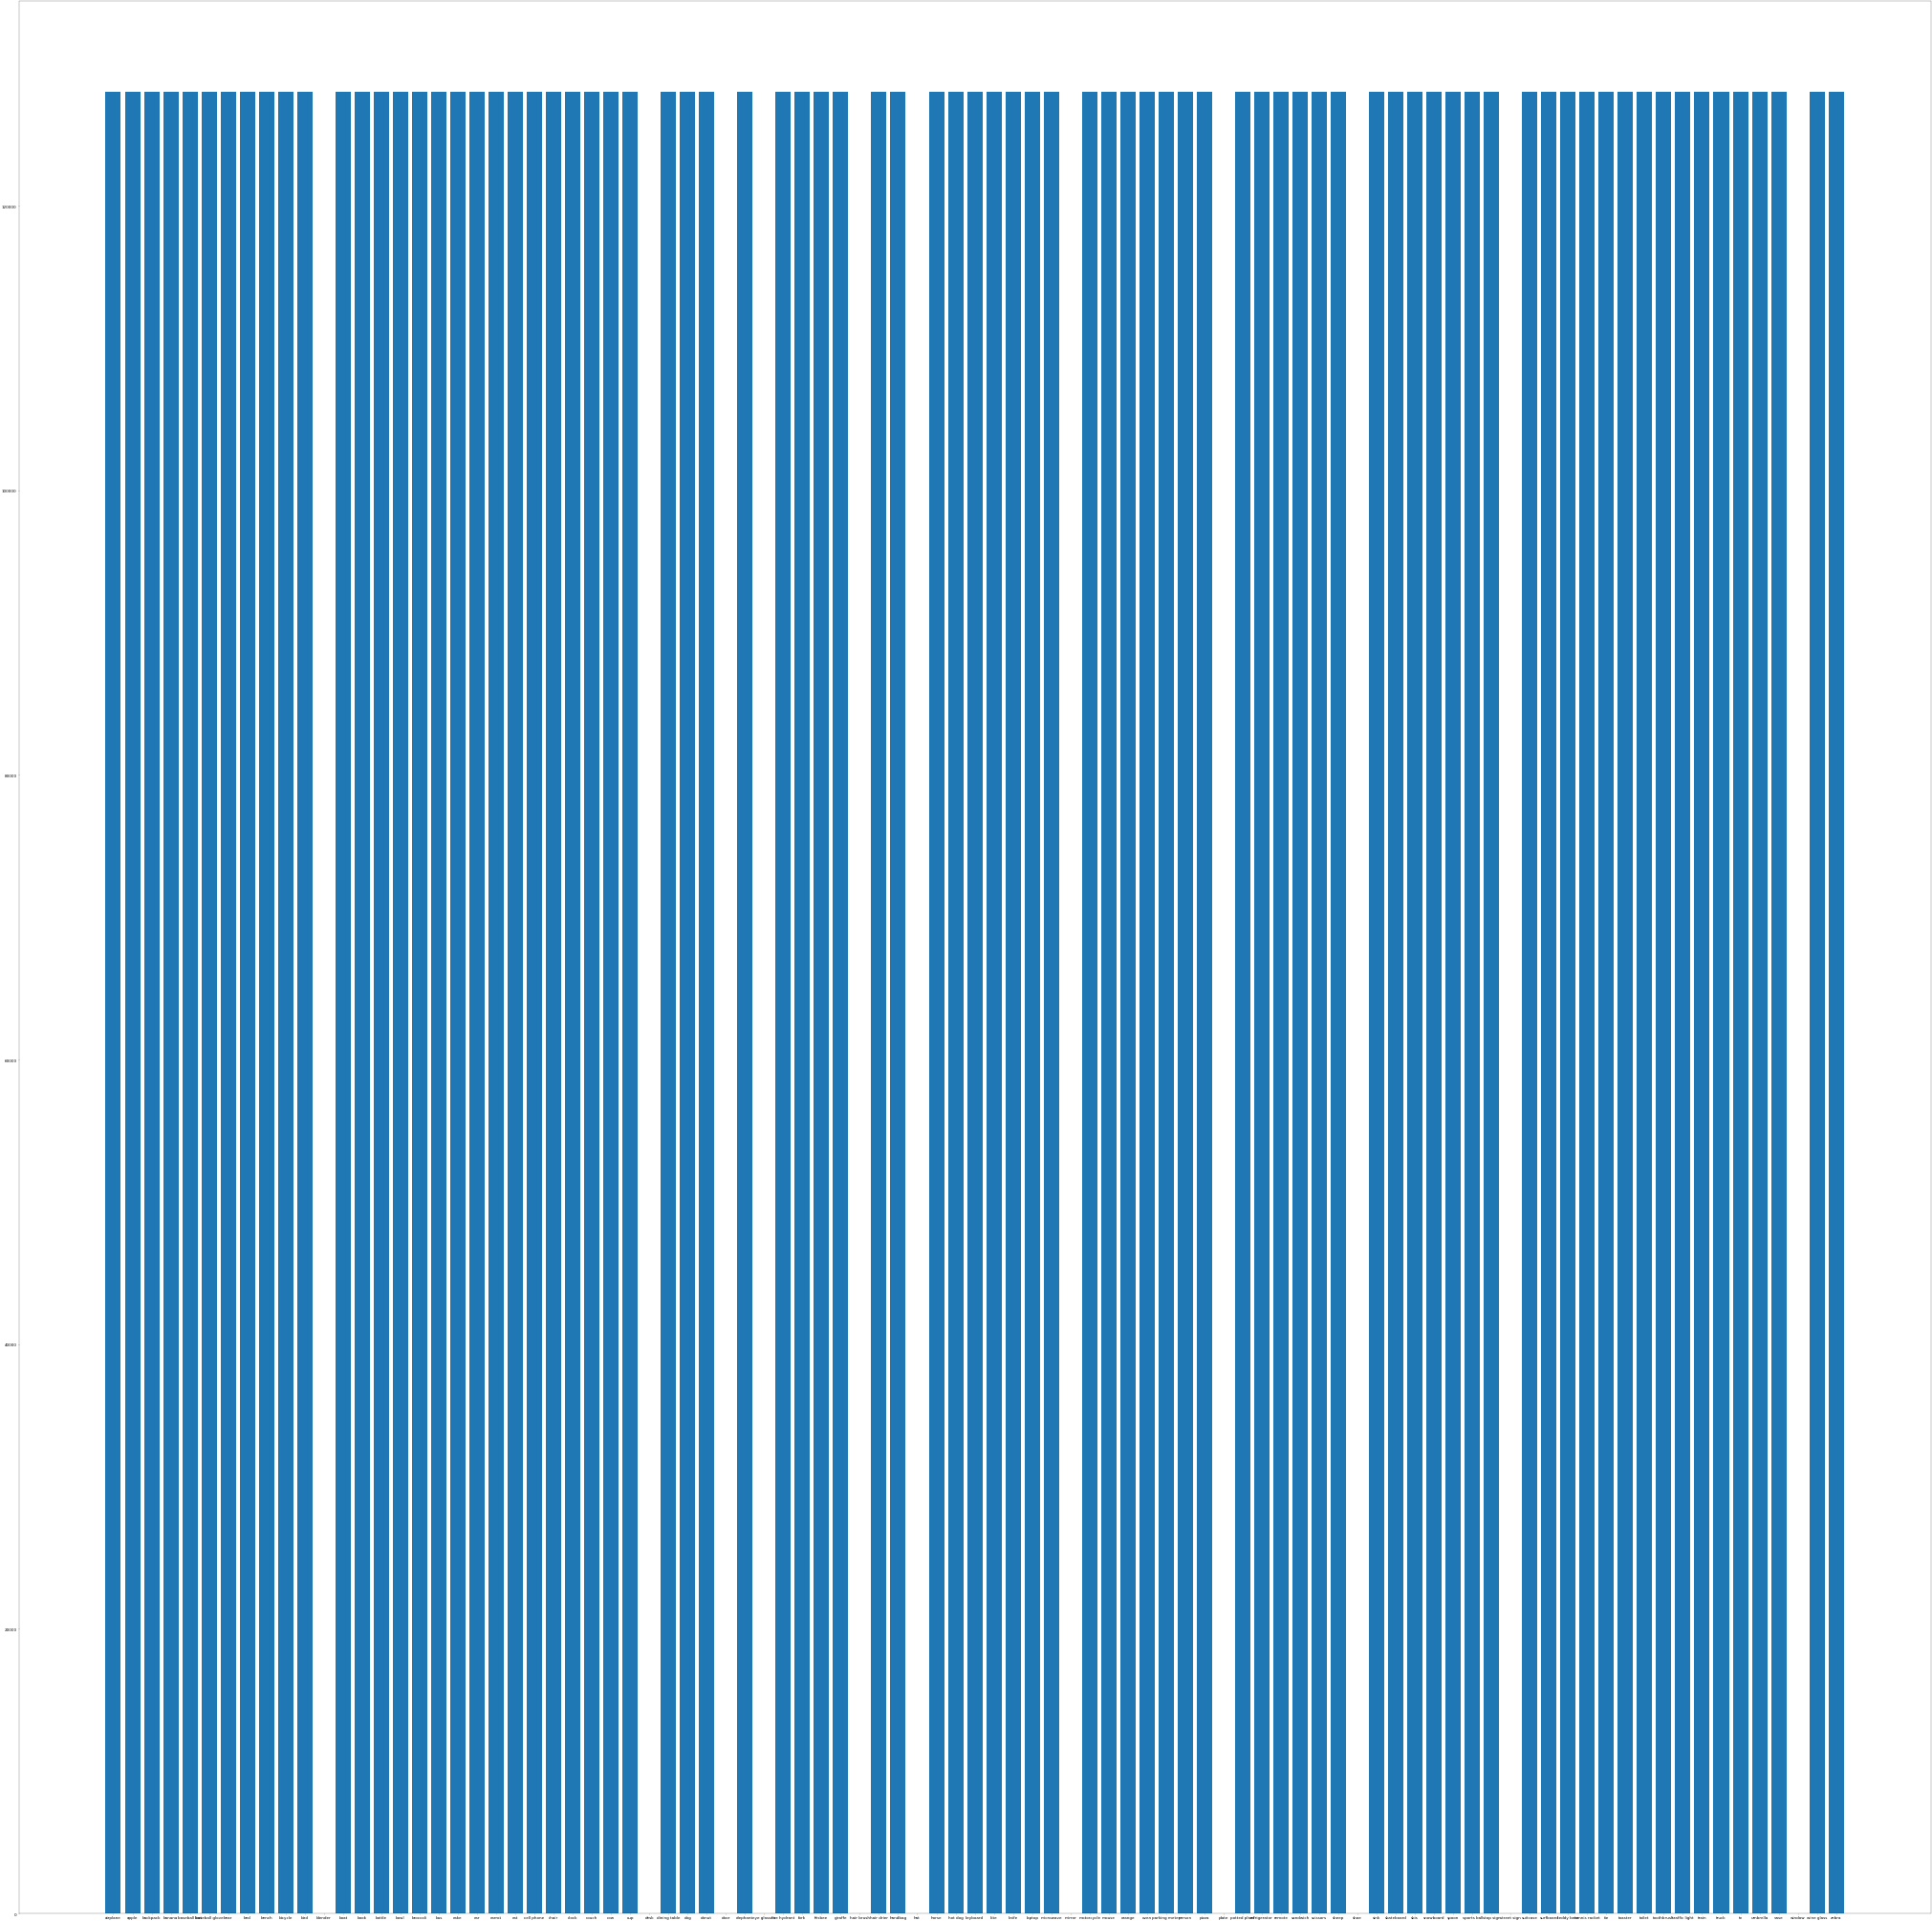

In [9]:
amounts = []
for c in os.listdir("data/coco_onehot_data"):
    amounts.append((c, len(os.listdir("data/coco_onehot_data/{0}".format(c)))))

amounts = np.array(amounts)
plt.rcParams.update({'font.size': 15})
fig = plt.pyplot.figure(figsize=(100,100), dpi=20)
ax = fig.add_axes([0,0,1,1])
ax.bar(amounts[:,0], np.asarray(amounts[:,1],dtype=int))

print(min({x for x in np.asarray(amounts[:,1],dtype=int) if x > 0}))
print(amounts[:,1])

In [5]:
def load_images(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img/255
    lbl = tf.strings.split(path, os.path.sep)[-2]
    lbl = lbl == coco_labels
    return img, tf.one_hot(tf.argmax(lbl), len(coco_labels))

tf_dataset = tf.data.Dataset.list_files('data/coco_onehot_data/*/*')

AUTOTUNE = tf.data.AUTOTUNE

val_size = int(len(tf_dataset)*0.1)
train_ds = tf_dataset.skip(val_size).map(load_images, num_parallel_calls=AUTOTUNE)
val_ds = tf_dataset.take(val_size).map(load_images, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

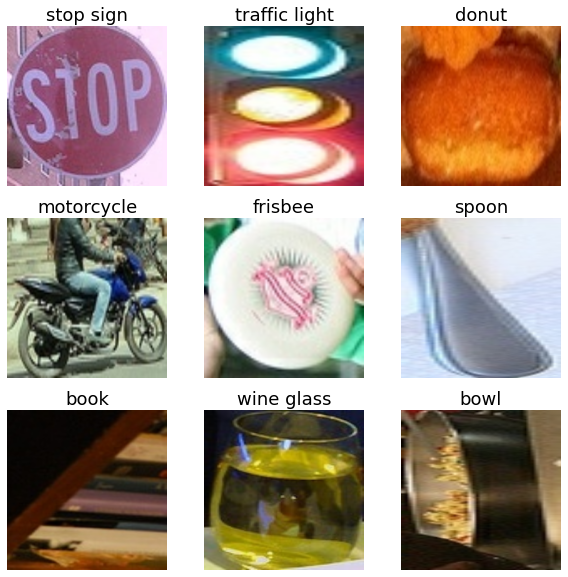

In [11]:
img_batch, lbl_batch = next(iter(train_ds))

plt.pyplot.figure(figsize=(10,10))
for i in range(9):
    ax = plt.pyplot.subplot(3,3,i+1)
    plt.pyplot.imshow(img_batch[i].numpy().astype("float32"))
    label = lbl_batch[i].numpy()
    label = np.where(label == 1)[0][0]
    plt.pyplot.title(coco_labels[label])
    plt.pyplot.axis("off")

In [6]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs/resnet34

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/resnet34/{0}'.format(current_time)
weight_dir = 'weights/resnet34/{0}'.format(current_time)

summary_writer = tf.summary.create_file_writer(log_dir)
summary_writer.set_as_default()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, update_freq=100)
weight_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=weight_dir,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_freq=10000)

Reusing TensorBoard on port 6006 (pid 174640), started 17:01:47 ago. (Use '!kill 174640' to kill it.)

In [8]:
resnet.model.load_weights("weights/resnet34/20220313-015642/variables/variables")

In [10]:
def train(EPOCHS):
    print("Starting training...")
        
    with summary_writer.as_default():
        tf.summary.text('configuration', CONFIG_STRING.format(BATCH_SIZE, LAST_DENSE, SOFTMAX_OUT, FROM_LOGITS, LEARNING_RATE, INFO), step=1)

    hist_train = resnet.model.fit(train_ds, batch_size=BATCH_SIZE, validation_batch_size=32, validation_data=val_ds, validation_steps=4, steps_per_epoch=1000, callbacks=[tensorboard_callback, weight_callback], epochs=EPOCHS)

train(1000)

Starting training...


f:\KOULU\opparii\Projekti\.venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/1000
1000/1000 [==============================] - 277s 254ms/step - loss: 0.5124 - tp: 25512.0000 - fp: 2550.0000 - tn: 2877450.0000 - fn: 6488.0000 - accuracy: 0.8437 - precision: 0.9091 - recall: 0.7972 - auc: 0.9943 - prc: 0.9238 - val_loss: 0.5242 - val_tp: 106.0000 - val_fp: 17.0000 - val_tn: 11503.0000 - val_fn: 22.0000 - val_accuracy: 0.8516 - val_precision: 0.8618 - val_recall: 0.8281 - val_auc: 0.9911 - val_prc: 0.9244
Epoch 2/1000
1000/1000 [==============================] - 259s 259ms/step - loss: 0.5354 - tp: 25294.0000 - fp: 2622.0000 - tn: 2877378.0000 - fn: 6706.0000 - accuracy: 0.8374 - precision: 0.9061 - recall: 0.7904 - auc: 0.9936 - prc: 0.9192 - val_loss: 0.5050 - val_tp: 107.0000 - val_fp: 8.0000 - val_tn: 11512.0000 - val_fn: 21.0000 - val_accuracy: 0.8594 - val_precision: 0.9304 - val_recall: 0.8359 - val_auc: 0.9910 - val_prc: 0.9328
Epoch 3/1000
1000/1000 [==============================] - 263s 263ms/step - loss: 0.5318 - tp: 25295.0000 - fp: 2648.0000

KeyboardInterrupt: 

In [12]:
resnet.model.save_weights(os.path.join(weight_dir, "weights"))

In [12]:

resnet.model.evaluate(validation_ds, verbose=1)


14/14 [==============================] - 2s 151ms/step - loss: 2.2457 - accuracy: 0.6529


[2.2457149028778076, 0.6528735756874084]